In [119]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Suppress annoying futures warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [120]:
wines = pd.read_csv('../data/wine.csv')
wines.columns = wines.columns.map(lambda x: x.replace(' ', '_')) # Convert spaces to underscores for easier lookups

In [ ]:
# pp.ProfileReport(wines)

# Data Cleaning

Based on the Profile Report above (code shown without output to keep things tidy), we have a few things to take care of at the surface level regarding data cleaning:



#### astringency_rating is highly correlated with fixed_acidity (ρ = 0.99262)

Since the correlation is nearly perfect between ```astringency_rating``` and ```fixed_acidity```, we should drop the one with less variance (information), which is ```astringency_rating```.

In [121]:
wines.drop(['astringency_rating'], axis=1, inplace=True)

#### citric acid has 151 / 2.3% zeros

According to this [link](https://www.livestrong.com/article/189520-what-drinks-do-not-contain-citric-acid/), red wine sometimes doesn't have any citric acid in it, so it makes sense that of all the wines with 0 citric acid, 87% are red.

In [122]:
wines[wines.citric_acid == 0].groupby('type').citric_acid.count() / 150

type
red      0.880000
white    0.126667
Name: citric_acid, dtype: float64

#### residual_sugar has 2364 / 36.4% missing, vintage has 69 / 1.1% missing, and volatile_acidity has 299 / 4.6% missing

Since this assignment is supposed to take 3-5 hours, I'm opting to impute each missing variable with its median.

#### Dataset has 109 duplicate rows

We need to drop duplicates so that our models don't overfit to a particular observation. To do this, we'll use the ```pandas.DataFrame.drop_duplicates()``` function.

In [123]:
wines.drop_duplicates(inplace=True)

#### Oversampling Considerations

In [124]:
print(wines.type.value_counts() / wines.type.size)

white    0.752039
red      0.247961
Name: type, dtype: float64


As shown by the output above, we have 3 times as much white wine than we have red wine in our dataset. This indicates an opportunity for over- or under-sampling consideration to balance out the dataset. If we get to it, that is.

#### Getting the types right

The ```type``` column has strings in it denoting whether a wine is red or white. We encode this as a binary flag to make the modeling process easier.

In [125]:
wines['red'] = wines.type.map({'red':1, 'white':0})
wines.drop(columns='type', axis=1, inplace=True)

# Visual Exploration

In [ ]:
wine_colors = {'red': '#790000', 'white': '#f1f285'}

In [126]:
wines.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'vintage', 'quality', 'red'],
      dtype='object')

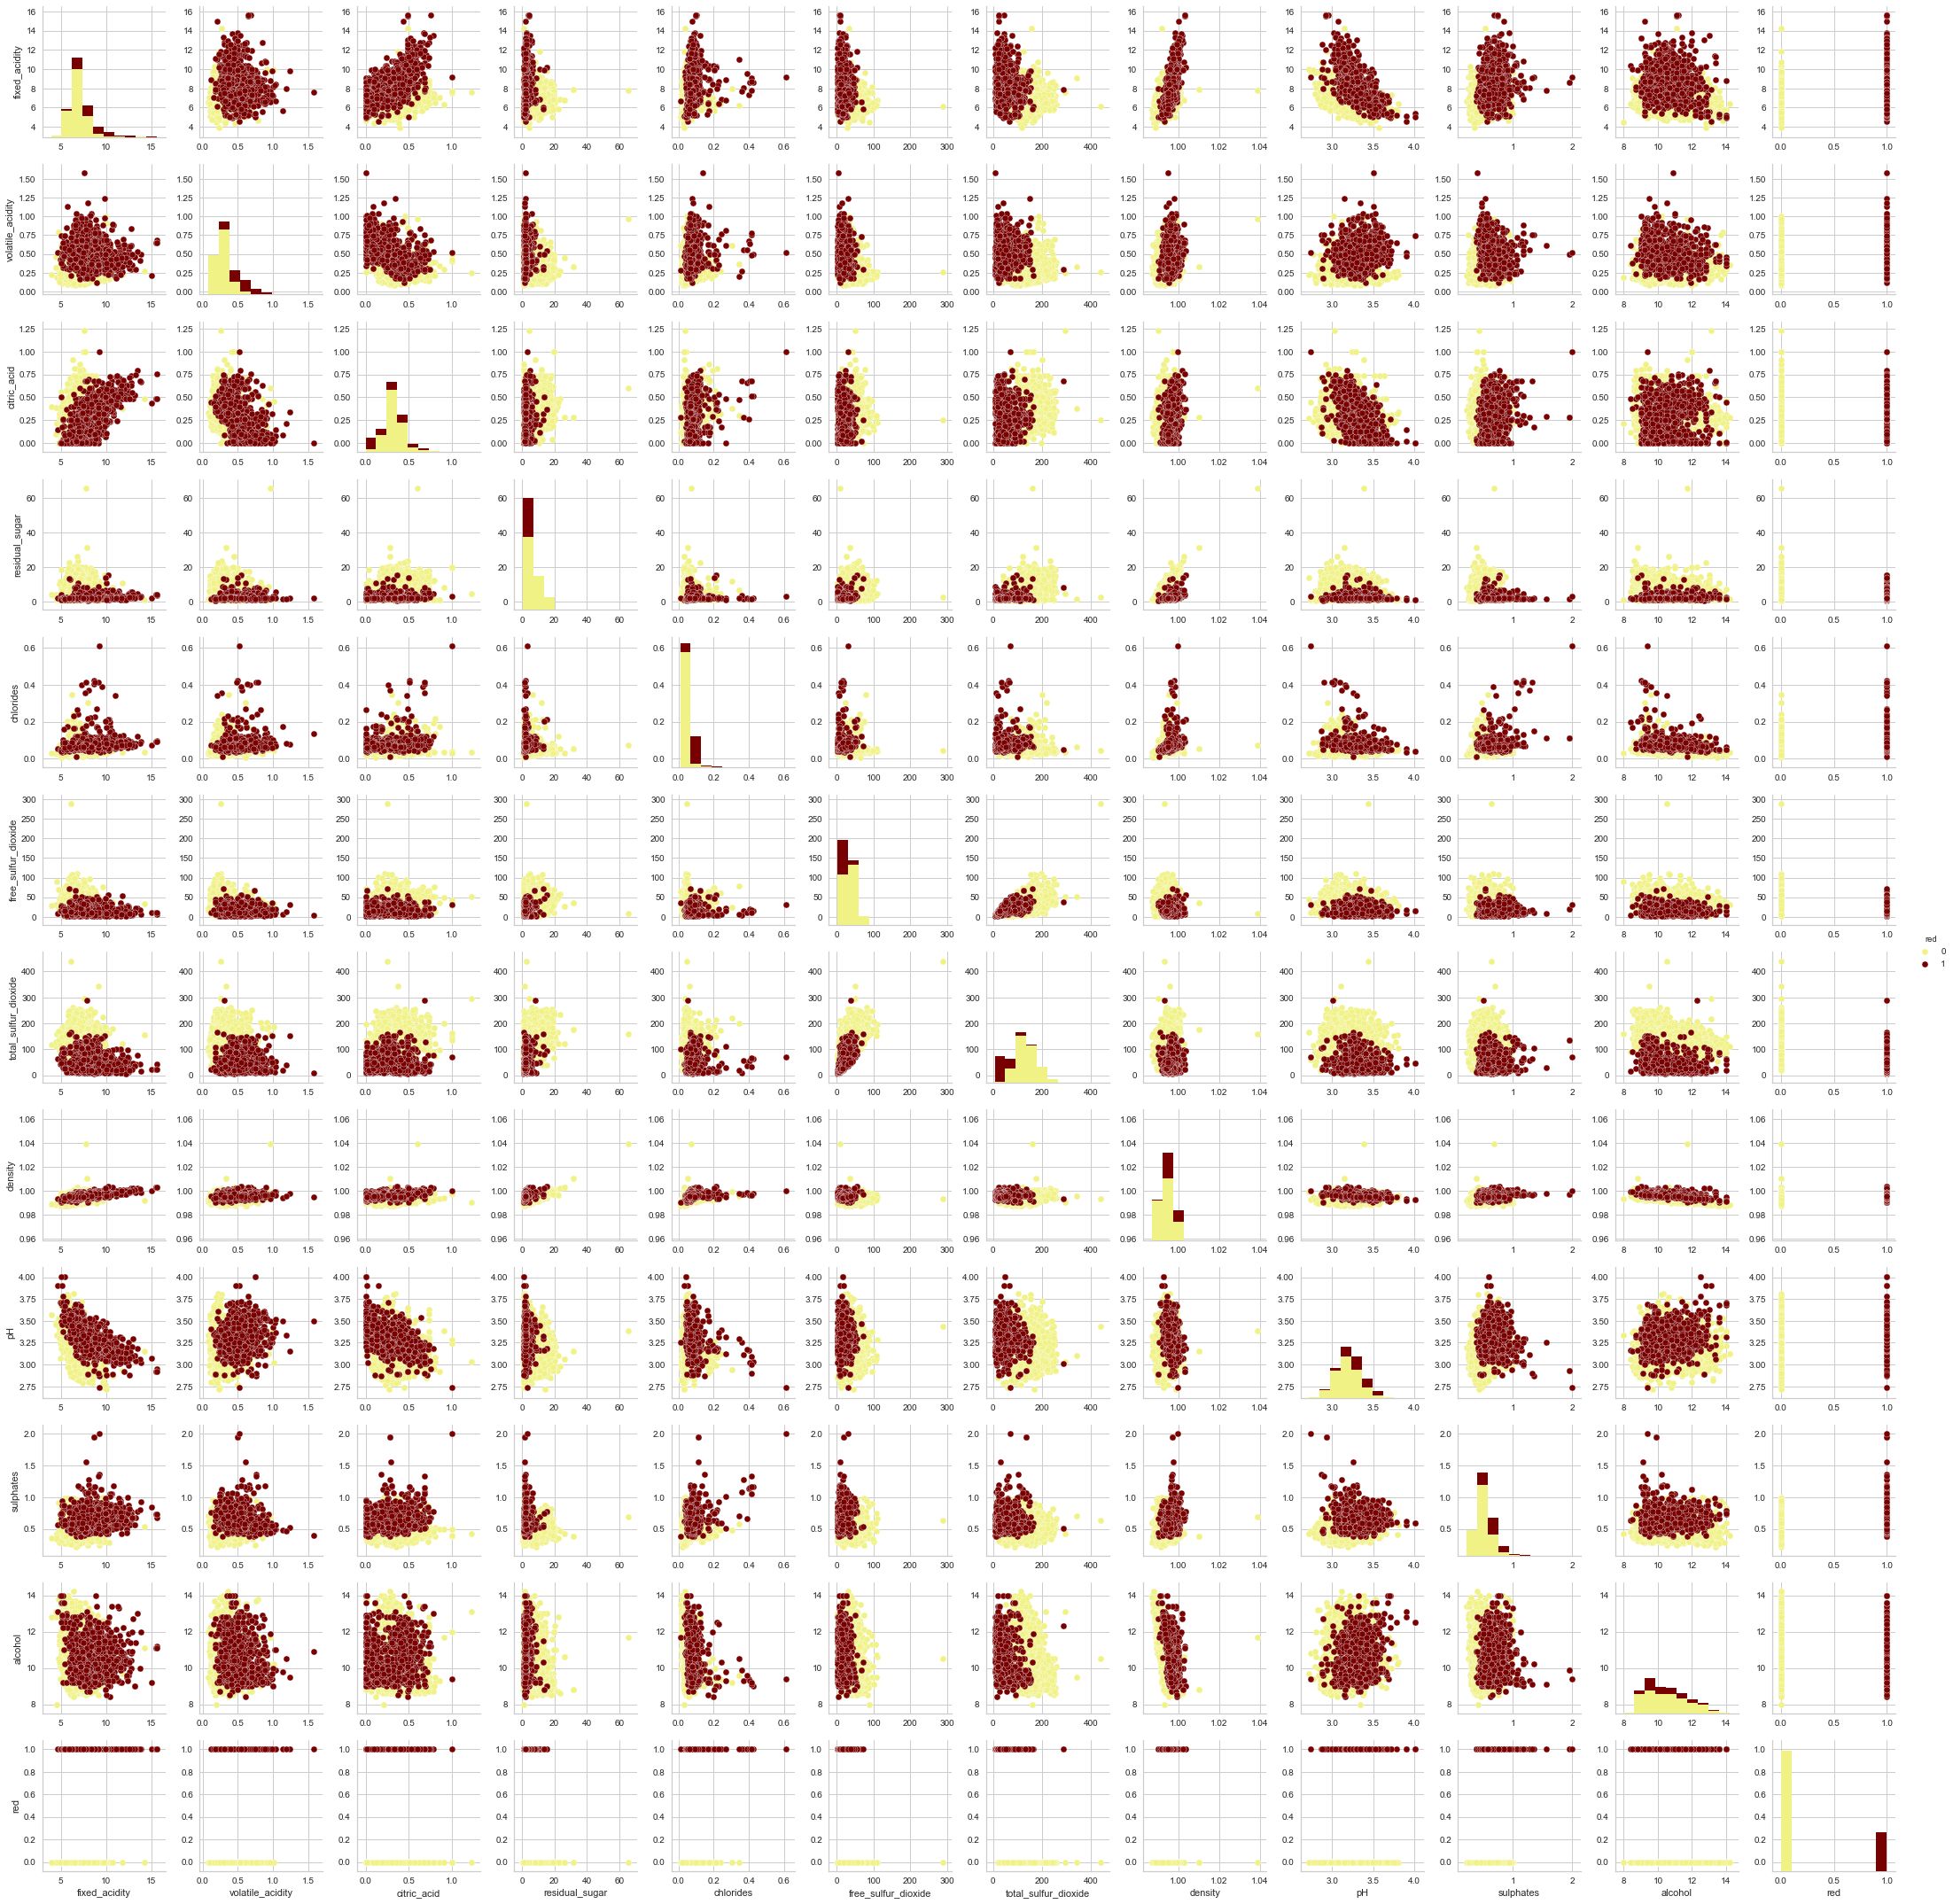

In [128]:
sns.pairplot(wines[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'red']].dropna(), 
             hue='red',
             palette={0: wine_colors['white'], 1: wine_colors['red']})

Well those are pretty...clumpy. Not super useful.

Let's get an idea of how qualities are distributed

C:\Users\samba\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


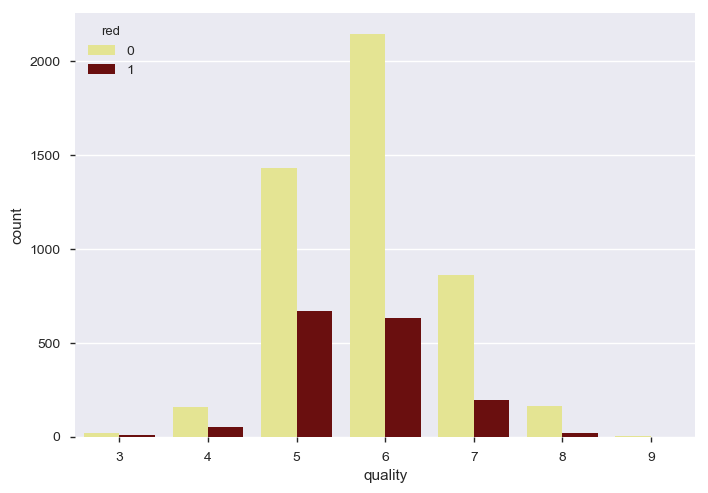

In [11]:
ax = sns.countplot(x='quality', hue='red', palette={0: wine_colors['white'], 1: wine_colors['red']}, data=wines)

Most wines are pretty average at around a 6. Very few are 3s or 9s. It looks like white wines tend to do better, though. Since there are so few wines in the top and bottom two quality categories, I will consider two bucketing methods:


##### Create a binary target
We can map wines < 6 to 0 and wines >= 6 to 1 so that we now have simpler binary classification problem. This simplifies the problem significantly, but it would basically be leaving information on the table regarding wine quality. However, given how few observations fall in the top and bottom two categories, it may actually make more sense.

##### Merge qualities into less granular bins
We can map wine qualities like so: [3, 4] => 0, [5, 6] => 1, and [7, 8, 9] => 2. This has the benefit of maintaining more information about quality rankings, but it has some sample size issues. The [3, 4] category would have 244 wines, [5, 6] would have 4884 wines, and the [7, 8, 9] category would have 1148 wines. Those groups aren't balanced at all, so over- or under-sampling would be an absolute must.


We will go with the first option, creating a binary target, because it greatly simplifies the analysis. We can also try shifting the cutoff point from 6 to 7 and see how that effects our results. 

## PCA

I'm kicking things off with PCA to see which variables tend to move together.

In [12]:
from sklearn.preprocessing import RobustScaler, Imputer
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline

In [13]:
X = wines.drop(columns=['quality'])
y = wines.quality.map({3:0, 4:0, 5:1, 6:1, 7:2, 8:2, 9:2})
features = X.columns.values

In [14]:
pca_pipeline = make_pipeline(Imputer(strategy='median'),
                             SMOTETomek(random_state=0),
                             RobustScaler(),
                             PCA(n_components=3))

pca_pipeline.fit(X, y)

# Percentage of variance explained for each components
print('Percent of variance explained by first five components: %s'
      % str(pca_pipeline.named_steps['pca'].explained_variance_ratio_))

Percent of variance explained by first five components: [ 0.37535873  0.2230022   0.11180833]


In [15]:
pca_scores = pd.DataFrame(pca_pipeline.named_steps['pca'].components_, index=['pc1', 'pc2', 'pc3'], columns=features).transpose()

In [16]:
pca_scores['pc1_rank'] = pca_scores.pc1.abs()
pca_scores.sort_values(['pc1_rank'], ascending=False).drop(['pc1_rank'], axis=1)

,pc1,pc2,pc3
red,-0.695732,0.253391,-0.143038
residual_sugar,0.392377,0.856969,-0.221874
chlorides,-0.336149,0.256921,0.302433
volatile_acidity,-0.277568,0.095990,-0.323948
total_sulfur_dioxide,0.212497,0.023603,0.103829
fixed_acidity,-0.193013,0.159205,0.420735
sulphates,-0.184943,0.095764,0.228115
free_sulfur_dioxide,0.167073,0.030695,0.090722
pH,-0.106885,-0.045861,-0.277944
citric_acid,0.097291,0.075155,0.632803


### PCA Results

The first principle component explains 38% of the variance. The ```red``` variable has the highest score. It looks like ```red``` and ```volatile_acidity``` tend to move together on all of the principle components.

The second principle component explains 22% of the variance. The ```residual_sugar``` variable has the highest score. Unlike in the first component, ```red``` and ```residual_sugar``` move in the same direction. This makes it difficult to generalize the relationship between the two variables. 

The third principle component explains 11% of the variance. The ```citric_acid``` variable has the highest score.

# Random Forests

In [17]:
def plot_feature_importances(model, features):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features, model):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [18]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
                  

## Training and Test Data Split

We are mapping qualities to good vs bad instead of the ordinal scale because it didn't give us great numbers. This will still give us an idea of what the biggest factors are that contribute to wine quality. 6 and above is good whereas 5 and below is bad.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Forest with all features

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC

First we have to define a couple of custom transformers for use in our pipeline. These two transformers allow us to use a ```DictVectorizer``` on a Pandas dataframe and easily perform cross-validation without leaking training data into our test data.

In [22]:
class DictTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.to_dict(orient='records')
    
    def get_params(self, **kwargs):
        return {}

class ArrayTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.toarray()
    
    def get_params(self, **kwargs):
        return {}

With our transformers defined, we instantiate all the different parts of our pipeline.

In [23]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rfc = RandomForestClassifier(n_estimators=50, random_state=42)

Next we map each of the random forest hyperparameters to distributions that the ```RandomizedSearchCV``` will map to. 

In [24]:
param_dist = {"randomforestclassifier__max_depth": [3, None],
              "randomforestclassifier__max_features": sp_randint(1, 14), 
              "randomforestclassifier__min_samples_split": sp_randint(2, 14),
              "randomforestclassifier__min_samples_leaf": sp_randint(1, 14),
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}

n_iter_search = 20
rfc_random_search = RandomizedSearchCV(make_pipeline(dt, dv, at, imp, smote, rfc), param_distributions=param_dist, n_iter=n_iter_search, random_state=42)

Fit the model, extract the best estimator, and output feature importances.

In [25]:
rfc_random_search.fit(X_train, y_train)
rf_cv_model = rfc_random_search.best_estimator_.steps[-1][1]

### Feature Importances

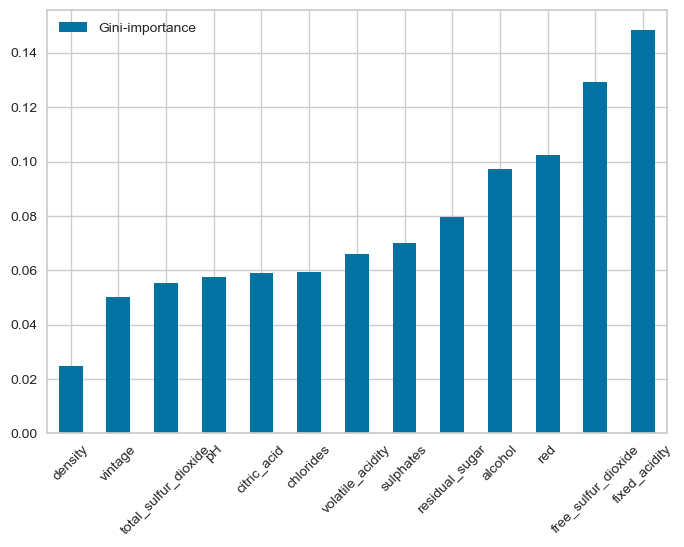

In [26]:
plot_feature_importances(rf_cv_model.feature_importances_, wines[features].columns)

### Use optimal hyperparameters

In [27]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rfc = RandomForestClassifier(**rf_cv_model.get_params())

rf_model = make_pipeline(dt, dv, at, imp, smote, rfc)

### Classification Report

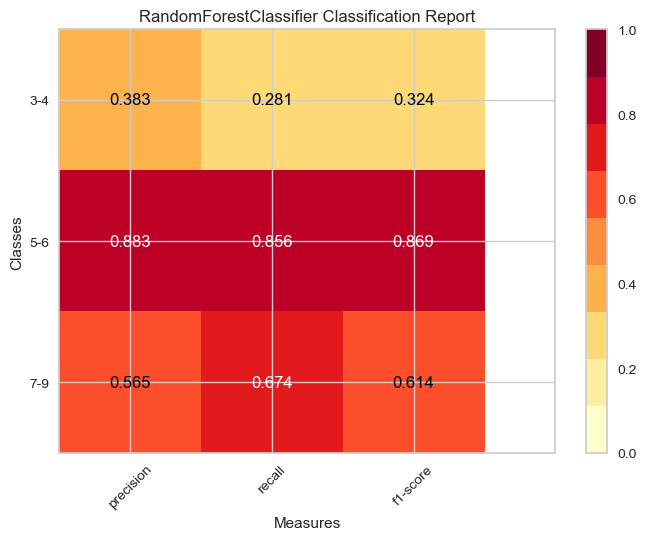

In [28]:
rf_report = ClassificationReport(rf_model, classes=['3-4', '5-6', '7-9'])
rf_report.fit(X_train, y_train)
rf_report.score(X_test, y_test)
rf_report.poof()

### Confusion Matrix

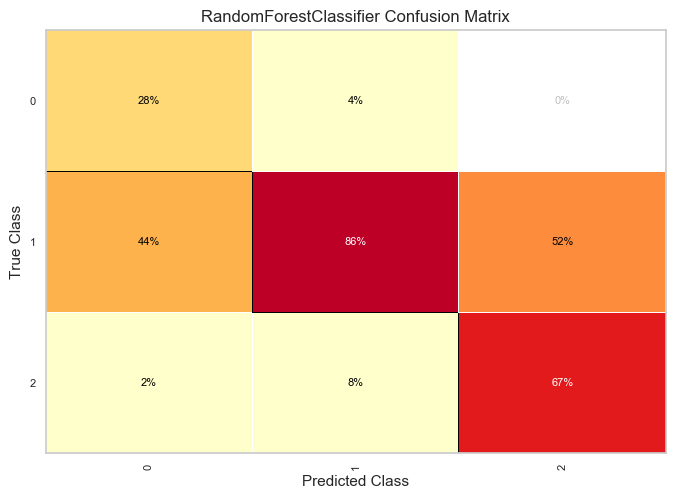

In [29]:
# Instantiate the classification model and visualizer
rf_cm = ConfusionMatrix(rf_model, classes=[0, 1, 2])
rf_cm.score(X_test, y_test)
rf_cm.poof()

### ROC Curve

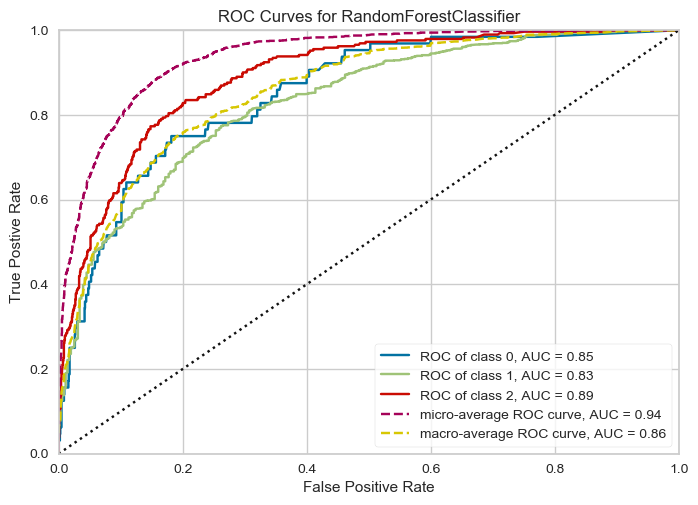

In [30]:
# Instantiate the classification model and visualizer
rf_roc_viz = ROCAUC(rf_model)
rf_roc_viz.fit(X_train, y_train)
rf_roc_viz.score(X_test, y_test)
rf_roc_viz.poof()

### Classification Report w/ Averages

In [31]:
print(classification_report(y_test, rf_model.predict(X_test), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.38      0.28      0.32        64
        5-6       0.88      0.86      0.87      1239
        7-9       0.56      0.67      0.61       291

avg / total       0.81      0.80      0.80      1594



### Accuracy

In [32]:
rf_model.score(X_test, y_test)

0.79924717691342539

### Feature Importances

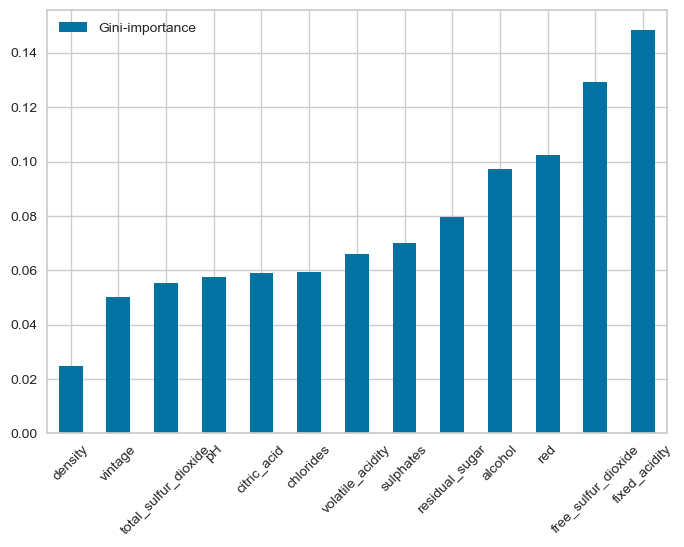

In [33]:
plot_feature_importances(rf_model.steps[-1][1].feature_importances_, wines[features].columns)

In [34]:
important_features = ['fixed_acidity', 'free_sulfur_dioxide', 'alcohol', 'red', 'residual_sugar', 'sulphates', 'volatile_acidity']

## Random Forest Classifier with the top 7 features

In [35]:
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X[important_features], y, random_state=42)

### Find optimal hyperparameters

In [36]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rfc_subset = RandomForestClassifier(n_estimators=50, random_state=42)

In [37]:
param_dist = {"randomforestclassifier__max_depth": [3, None],
              "randomforestclassifier__max_features": sp_randint(1, 7), 
              "randomforestclassifier__min_samples_split": sp_randint(2, 14),
              "randomforestclassifier__min_samples_leaf": sp_randint(1, 14),
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}

n_iter_search = 20
rfc_subset_random_search = RandomizedSearchCV(make_pipeline(dt, dv, at, imp, smote, rfc_subset), param_distributions=param_dist, n_iter=n_iter_search, random_state=42)

In [38]:
rfc_subset_random_search.fit(X_train_subset, y_train_subset)
rfc_subset_cv_model = rfc_subset_random_search.best_estimator_.steps[-1][1]

### Use optimal hyperparameters

In [39]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rfc_subset = RandomForestClassifier(**rfc_subset_cv_model.get_params())

rf_subset_model = make_pipeline(dt, dv, at, imp, smote, rfc_subset)

### Classification Report

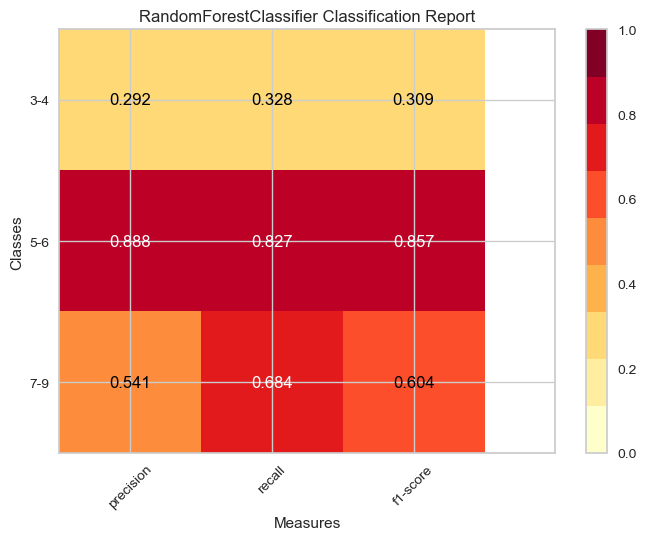

In [40]:
rf_report = ClassificationReport(rf_subset_model, classes=['3-4', '5-6', '7-9'])
rf_report.fit(X_train_subset, y_train_subset)
rf_report.score(X_test_subset, y_test_subset)
rf_report.poof()

### Feature Importances

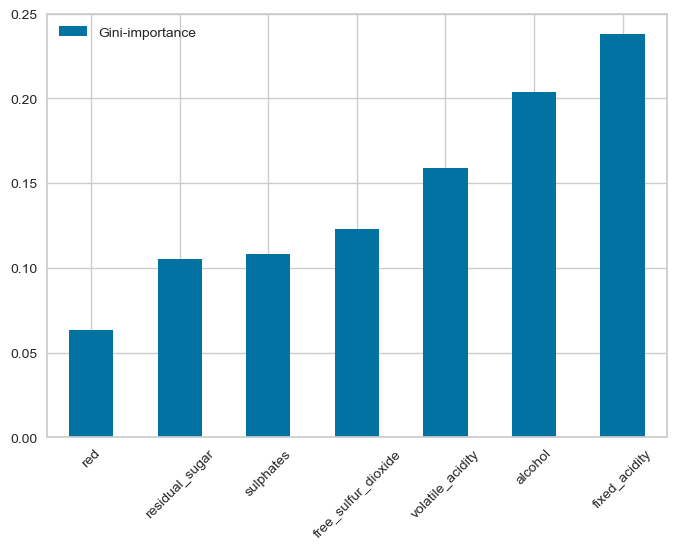

In [41]:
plot_feature_importances(rf_subset_model.steps[-1][1].feature_importances_, wines[important_features].columns)

### Classification Report w/ Averages

In [42]:
print(classification_report(y_test_subset, rf_subset_model.predict(X_test_subset), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.29      0.33      0.31        64
        5-6       0.89      0.83      0.86      1239
        7-9       0.54      0.68      0.60       291

avg / total       0.80      0.78      0.79      1594



### Accuracy

In [43]:
print(rf_subset_model.score(X_test_subset, y_test_subset))

0.781053952321


We see a minimal drop in accuracy and f1-score for our random forest after subsetting to the top 7 most important variables, and we are predicting the 3-4 and 7-9 classes better than before. **This will end up as our champion model.**

## Ridge Classification

In [44]:
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

### Hyperparameter Tuning

In [45]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rs = RobustScaler()
rccv = RidgeClassifierCV()

rc_cv_model = make_pipeline(dt, dv, at, imp, smote, rs, rccv)

In [46]:
rc_cv_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dicttransformer', <__main__.DictTransformer object at 0x000002D2DA0F29B0>), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('arraytransformer', <__main__.ArrayTransformer object at 0x000002D2DA0F2B38>), ('imputer', Imputer(a....0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None))])

### Classification Report

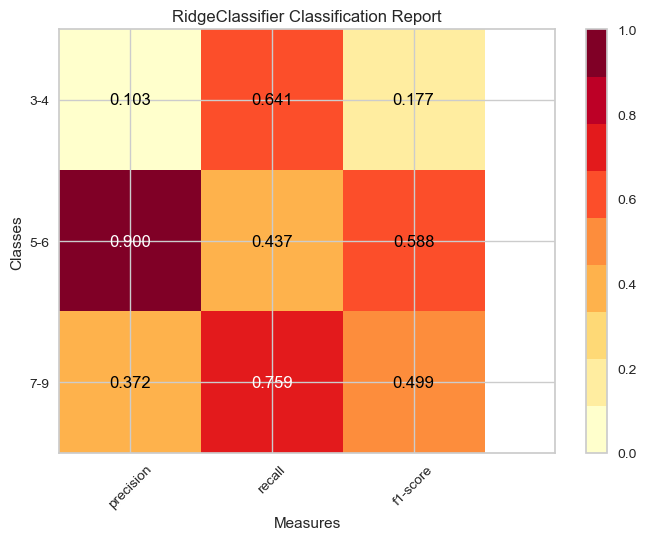

In [47]:
rc_model = make_pipeline(dt, dv, at, imp, smote, rs, RidgeClassifier(alpha=rc_cv_model.steps[-1][1].alpha_, fit_intercept=True))
rc_report = ClassificationReport(rc_model, classes=['3-4', '5-6', '7-9'])
rc_report.fit(X_train, y_train)
rc_report.score(X_test, y_test)
rc_report.poof()

### Confusion Matrix

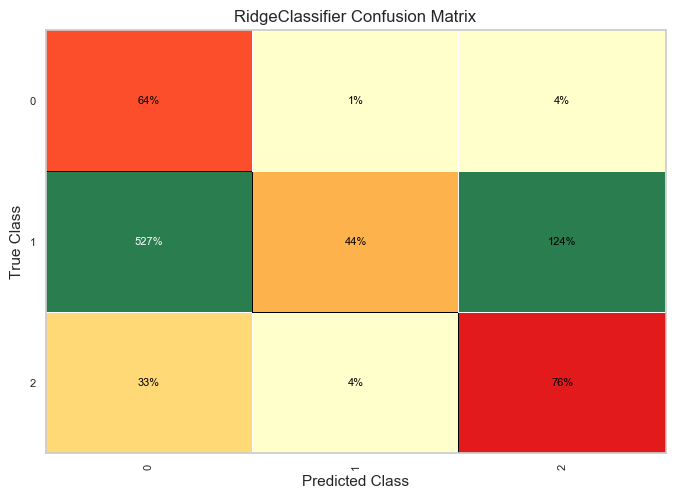

In [48]:
rc_cm = ConfusionMatrix(rc_model, classes=[0, 1, 2])
rc_cm.score(X_test, y_test)
rc_cm.poof()

### ROC Curve

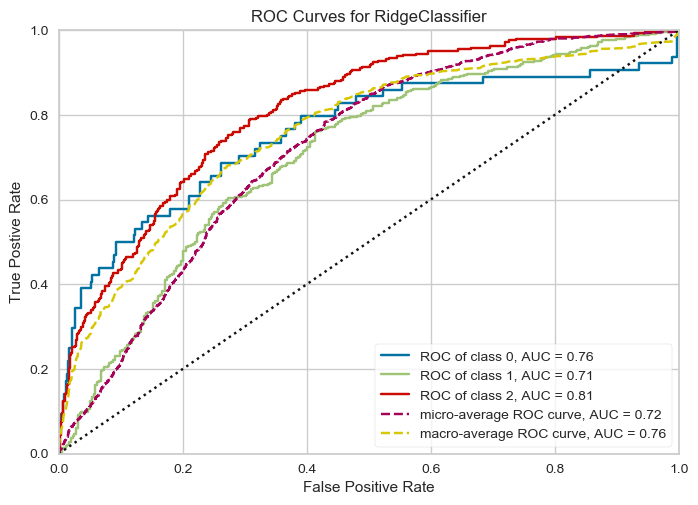

In [49]:
rc_roc_viz = ROCAUC(rc_model)
rc_roc_viz.fit(X_train, y_train)
rc_roc_viz.score(X_test, y_test)
rc_roc_viz.poof()

### Classification Report w/ Averages

In [50]:
print(classification_report(y_test, rc_model.predict(X_test), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.10      0.64      0.18        64
        5-6       0.90      0.44      0.59      1239
        7-9       0.37      0.76      0.50       291

avg / total       0.77      0.50      0.56      1594



### Parameters

In [52]:
rc_params = pd.DataFrame(rc_model.steps[-1][1].coef_, index=['3-4', '5-6', '7-9'], columns=features)

In [53]:
rc_params

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,vintage,red
3-4,-0.451932,0.037988,-0.031620,-0.030975,0.104465,-0.354802,0.040449,-0.176051,-0.052693,-0.011552,-0.095092,-0.065412,0.399548
5-6,-0.195521,0.000056,0.032372,0.144333,-0.171652,0.106807,-0.133232,0.144164,0.011741,-0.080677,0.145054,0.067062,-0.173320
7-9,0.647453,-0.038044,-0.000752,-0.113358,0.067187,0.247994,0.092782,0.031887,0.040952,0.092229,-0.049963,-0.001651,-0.226229


In [54]:
rc_model.score(X_test, y_test)

0.50376411543287325

# Support Vector Machines

In [55]:
from sklearn.svm import SVC

## SVC with all variables

### Find optimal hyperparameters

In [56]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rs = RobustScaler()
svc = SVC()

svc_cv_model = make_pipeline(dt, dv, at, imp, smote, rs, svc)

In [57]:
param_dist = {"svc__C": np.logspace(-3, 3),
              "svc__gamma": np.logspace(-3, 3)}

n_iter_search = 5
svc_random_search = RandomizedSearchCV(svc_cv_model, param_distributions=param_dist, n_iter=n_iter_search, random_state=42)

In [58]:
svc_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('dicttransformer', <__main__.DictTransformer object at 0x000002D2E0B44D30>), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('arraytransformer', <__main__.ArrayTransformer object at 0x000002D2E0B44BE0>), ('imputer', Imputer(a...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'svc__C': array([  1.00000e-03,   1.32571e-03,   1.75751e-03,   2.32995e-03,
         3.08884e-03,   4.09492e-03,   5.42868e-03,   7.19686e-03,
         9.54095e-03,   1.26486e-02,   1.67683e-02,   2.22300e-02,
         2.94705e-02,   3.90694e-02,   5.17947e-02,   6.86649e-02,
 ...    2.44205e+02,   3.23746e+02,   4.29193e+02,   5.68987e+02,
         7.54312e+02,   1.00000e+03])},
          pre_dispatch='2*

### Use optimal hyperparameters

In [59]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rs = RobustScaler()
svc = SVC(**svc_random_search.best_estimator_.steps[-1][1].get_params())

svc_model = make_pipeline(dt, dv, at, imp, smote, rs, svc)

### Classification Report

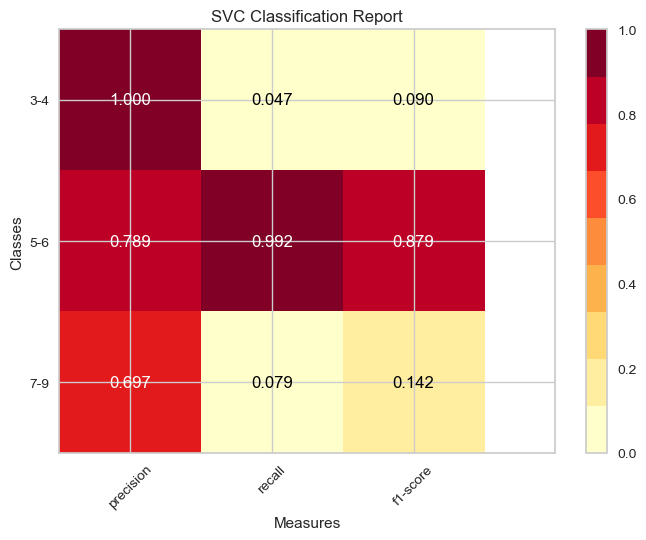

In [60]:
svc_report = ClassificationReport(svc_model, classes=['3-4', '5-6', '7-9'])
svc_report.fit(X_train, y_train)
svc_report.score(X_test, y_test)
svc_report.poof()

### Confusion Matrix

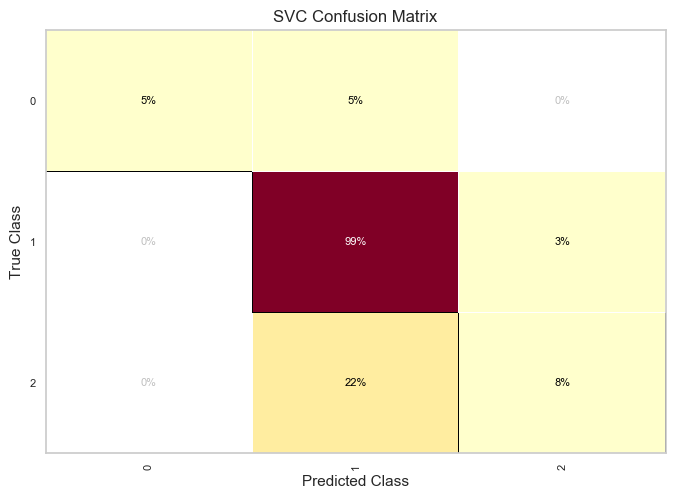

In [61]:
svc_cm = ConfusionMatrix(svc_model, classes=[0, 1, 2])
svc_cm.score(X_test, y_test)
svc_cm.poof()

### ROC Curve

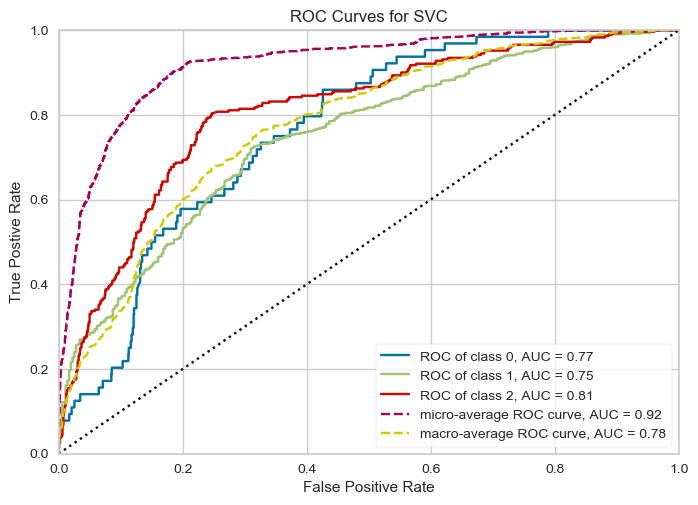

In [62]:
svc_roc_viz = ROCAUC(svc_model)
svc_roc_viz.fit(X_train, y_train)
svc_roc_viz.score(X_test, y_test)
svc_roc_viz.poof()

### Classification Report w/ Averages

In [63]:
print(classification_report(y_test, svc_model.predict(X_test), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       1.00      0.05      0.09        64
        5-6       0.79      0.99      0.88      1239
        7-9       0.70      0.08      0.14       291

avg / total       0.78      0.79      0.71      1594



### Accuracy

In [64]:
svc_model.score(X_test, y_test)

0.78732747804266001

## SVC with top 7 most important features

In [65]:
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X[important_features], y, random_state=42)

### Find optimal hyperparameters

In [66]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rs = RobustScaler()
svc = SVC()

svc_cv_model = make_pipeline(dt, dv, at, imp, smote, rs, svc)

In [67]:
param_dist = {"svc__C": np.logspace(-3, 3),
              "svc__gamma": np.logspace(-3, 3)}

n_iter_search = 10
svc_random_search = RandomizedSearchCV(svc_cv_model, param_distributions=param_dist, n_iter=n_iter_search, random_state=42)

In [68]:
svc_random_search.fit(X_train_subset, y_train_subset)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('dicttransformer', <__main__.DictTransformer object at 0x000002D2E0B888D0>), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('arraytransformer', <__main__.ArrayTransformer object at 0x000002D2E0B88780>), ('imputer', Imputer(a...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'svc__C': array([  1.00000e-03,   1.32571e-03,   1.75751e-03,   2.32995e-03,
         3.08884e-03,   4.09492e-03,   5.42868e-03,   7.19686e-03,
         9.54095e-03,   1.26486e-02,   1.67683e-02,   2.22300e-02,
         2.94705e-02,   3.90694e-02,   5.17947e-02,   6.86649e-02,
 ...    2.44205e+02,   3.23746e+02,   4.29193e+02,   5.68987e+02,
         7.54312e+02,   1.00000e+03])},
          pre_dispatch='2

### Use optimal hyperparameters

In [69]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
rs = RobustScaler()
svc = SVC(**svc_random_search.best_estimator_.steps[-1][1].get_params())

svc_model = make_pipeline(dt, dv, at, imp, smote, rs, svc)

### Classification Report

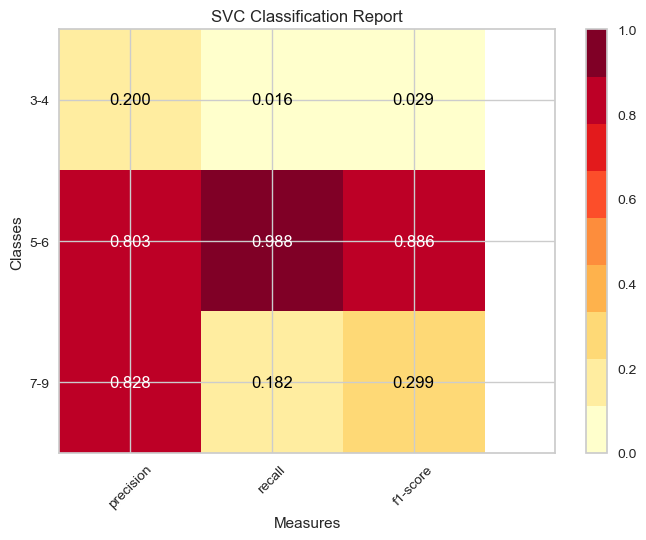

In [70]:
svc_report = ClassificationReport(svc_model, classes=['3-4', '5-6', '7-9'])
svc_report.fit(X_train_subset, y_train_subset)
svc_report.score(X_test_subset, y_test_subset)
svc_report.poof()

### Confusion Matrix

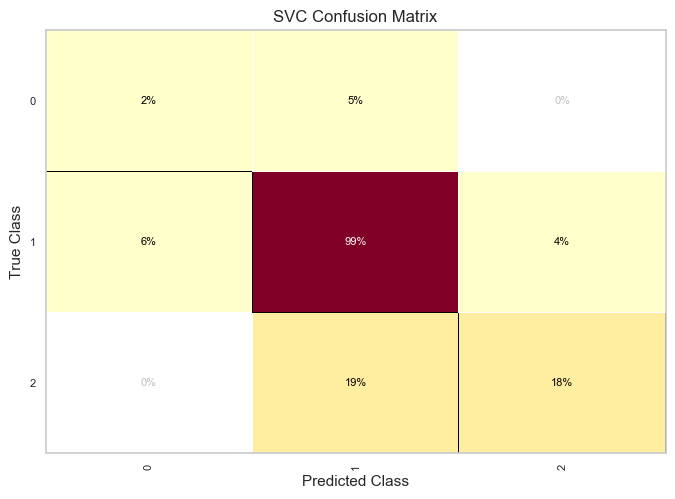

In [71]:
svc_cm = ConfusionMatrix(svc_model, classes=[0, 1, 2])
svc_cm.score(X_test_subset, y_test_subset)
svc_cm.poof()

### ROC Curve

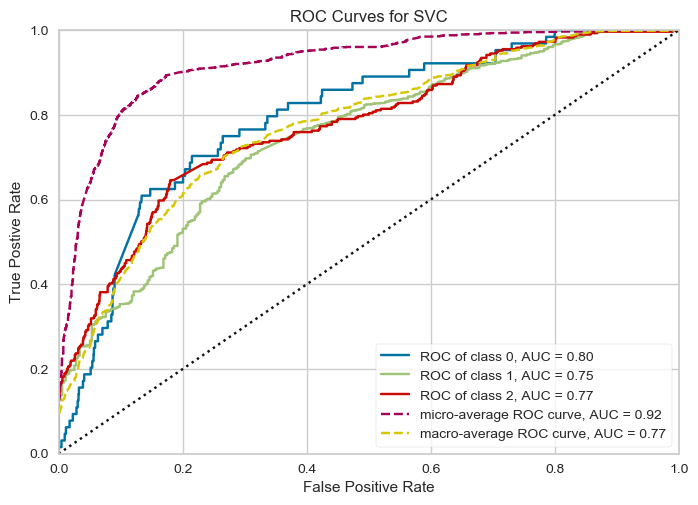

In [72]:
svc_roc_viz = ROCAUC(svc_model)
svc_roc_viz.fit(X_train_subset, y_train_subset)
svc_roc_viz.score(X_test_subset, y_test_subset)
svc_roc_viz.poof()

### Classification Report w/ Averages

In [73]:
print(classification_report(y_test_subset, svc_model.predict(X_test_subset), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.20      0.02      0.03        64
        5-6       0.80      0.99      0.89      1239
        7-9       0.83      0.18      0.30       291

avg / total       0.78      0.80      0.74      1594



### Accuracy

In [74]:
svc_model.score(X_test_subset, y_test_subset)

0.80175658720200749

# Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

## Logistic Regression with all variables

### Find optimal hyperparameters

In [76]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
lr_cv = LogisticRegression(multi_class='multinomial', solver='lbfgs')

lr_cv_pipeline = make_pipeline(dt, dv, at, imp, smote, lr_cv)

In [77]:
param_dist = {'lr__C': np.logspace(-3, 3)}
n_iter_search = 20
lr_cv_random_search = RandomizedSearchCV(lr_cv_pipeline, param_distributions=param_dist, n_iter=n_iter_search)

### Use optimal hyperparameters

In [79]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
lr = LogisticRegression(**lr_cv_random_search.estimator.steps[-1][1].get_params())

lr_model = make_pipeline(dt, dv, at, imp, smote, lr)

### Classification Report

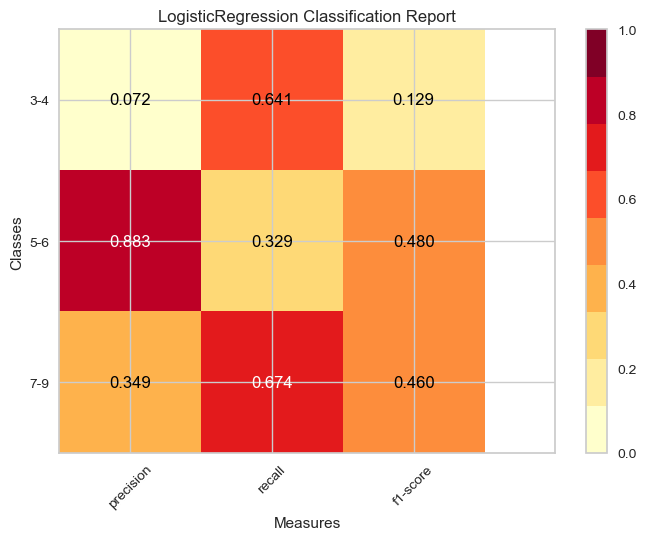

In [80]:
lr_report = ClassificationReport(lr_model, classes=['3-4', '5-6', '7-9'])
lr_report.fit(X_train, y_train)
lr_report.score(X_test, y_test)
lr_report.poof()

### Confusion Matrix

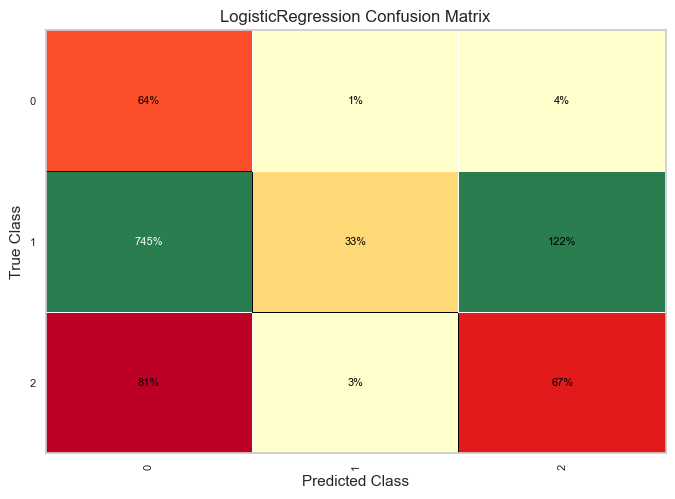

In [81]:
lr_cm = ConfusionMatrix(lr_model, classes=[0, 1, 2])
lr_cm.score(X_test, y_test)
lr_cm.poof()

### ROC Curve

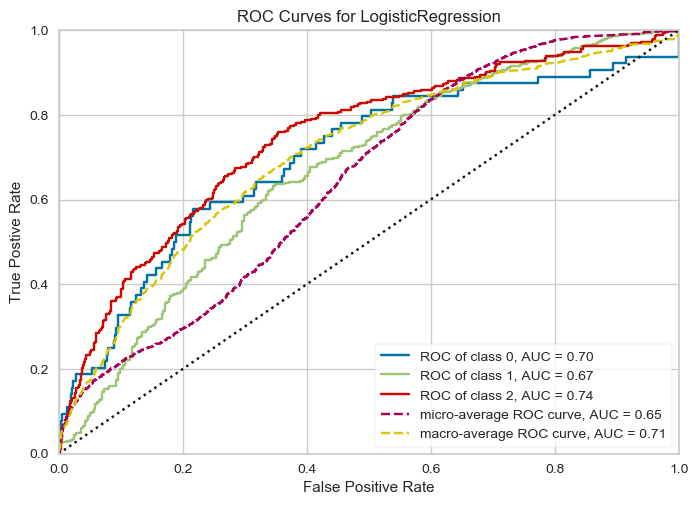

In [82]:
lr_roc_viz = ROCAUC(lr_model)
lr_roc_viz.fit(X_train, y_train)
lr_roc_viz.score(X_test, y_test)
lr_roc_viz.poof()

### Classification Report w/ Averages

In [83]:
print(classification_report(y_test, lr_model.predict(X_test), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.07      0.64      0.13        64
        5-6       0.88      0.33      0.48      1239
        7-9       0.35      0.67      0.46       291

avg / total       0.75      0.40      0.46      1594



### Parameter Estimates

In [84]:
lr_params = pd.DataFrame(lr_model.steps[-1][1].coef_, index=['3-4', '5-6', '7-9'], columns=features)

In [85]:
lr_params

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,vintage,red
3-4,-0.191339,0.002140,-0.011134,0.000259,0.025431,-0.041869,-0.000036,-0.001313,-0.073322,-0.006889,0.005634,0.001303,0.030583
5-6,-0.142367,0.002076,0.001288,0.000310,0.025957,0.012009,-0.002377,0.030235,0.134025,0.001820,-0.002153,0.000377,-0.002047
7-9,0.333705,-0.004216,0.009846,-0.000569,-0.051388,0.029859,0.002413,-0.028922,-0.060703,0.005069,-0.003481,-0.001680,-0.028536


## Logistic Regression with top 7 most important features

In [86]:
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X[important_features], y, random_state=42)

### Find optimal hyperparameters

In [87]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
lr_cv = LogisticRegression(multi_class='multinomial', solver='lbfgs')

lr_cv_pipeline = make_pipeline(dt, dv, at, imp, smote, lr_cv)

In [88]:
param_dist = {'lr__C': np.logspace(-3, 3)}
n_iter_search = 20
lr_cv_random_search = RandomizedSearchCV(lr_cv_pipeline, param_distributions=param_dist, n_iter=n_iter_search)

### Use optimal hyperparameters

In [89]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
imp = Imputer(strategy='median')
smote = SMOTETomek(random_state=0)
lr = LogisticRegression(**lr_cv_random_search.estimator.steps[-1][1].get_params())

lr_model = make_pipeline(dt, dv, at, imp, smote, lr)

### Classification Report

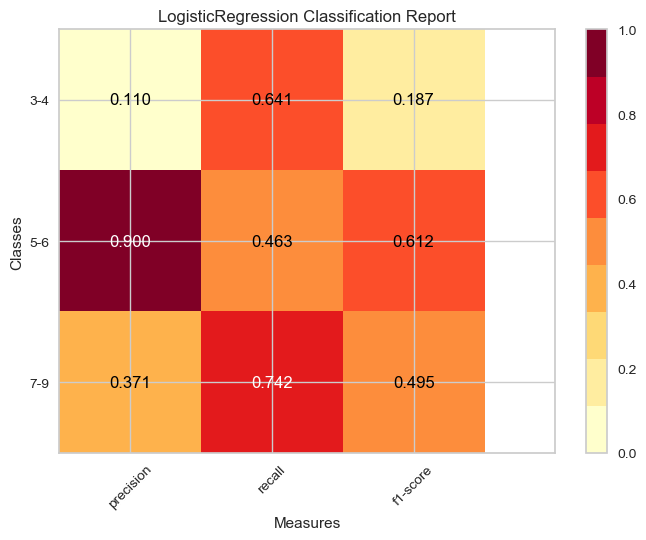

In [90]:
lr_report = ClassificationReport(lr_model, classes=['3-4', '5-6', '7-9'])
lr_report.fit(X_train_subset, y_train_subset)
lr_report.score(X_test_subset, y_test_subset)
lr_report.poof()

### Confustion Matrix

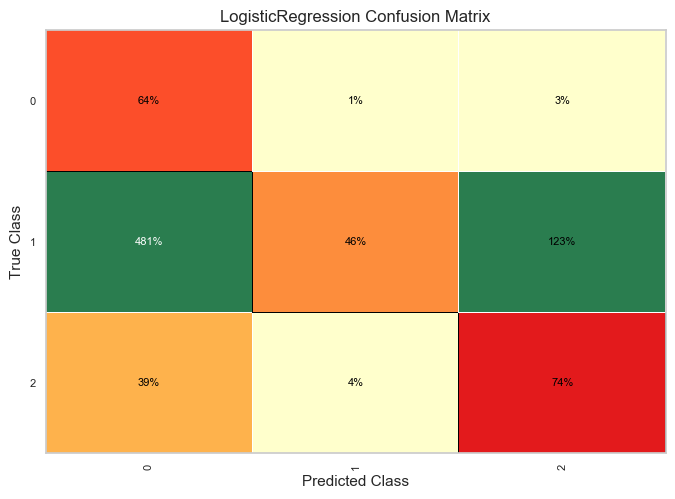

In [91]:
lr_cm = ConfusionMatrix(lr_model, classes=[0, 1, 2])
lr_cm.score(X_test_subset, y_test_subset)
lr_cm.poof()

### ROC Curve

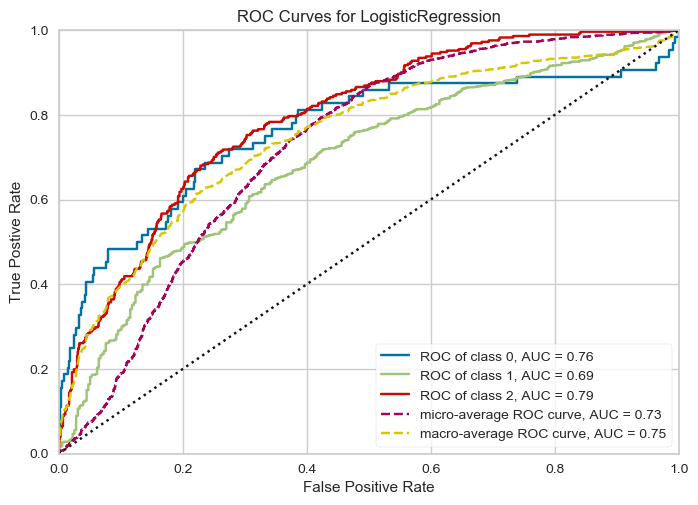

In [92]:
lr_roc_viz = ROCAUC(lr_model)
lr_roc_viz.fit(X_train_subset, y_train_subset)
lr_roc_viz.score(X_test_subset, y_test_subset)
lr_roc_viz.poof()

### Classification Report w/ Averages

In [93]:
print(classification_report(y_test_subset, lr_model.predict(X_test_subset), target_names=['3-4', '5-6', '7-9']))

             precision    recall  f1-score   support

        3-4       0.11      0.64      0.19        64
        5-6       0.90      0.46      0.61      1239
        7-9       0.37      0.74      0.49       291

avg / total       0.77      0.52      0.57      1594



### Parameter Estimates

In [94]:
lr_params = pd.DataFrame(lr_model.steps[-1][1].coef_, index=['3-4', '5-6', '7-9'], columns=important_features)

In [95]:
lr_params

,fixed_acidity,free_sulfur_dioxide,alcohol,red,residual_sugar,sulphates,volatile_acidity
3-4,-0.516092,0.269905,-0.032668,-2.747102,-0.075569,-0.353505,6.992325
5-6,-0.077332,-0.037588,0.016671,1.239095,0.040470,-0.244519,-1.453580
7-9,0.593424,-0.232317,0.015996,1.508007,0.035099,0.598024,-5.538746


### Accuracy

In [96]:
lr_model.score(X_test_subset, y_test_subset)

0.52132998745294856

## Logistic Regression with R-like output via statsmodels

In [97]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df) # Workaround bc chisqprob has been deprecated in scipy.stats

C:\Users\samba\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [98]:
smote_pipeline = make_pipeline(Imputer(strategy='median'), SMOTETomek(random_state=0))
X_train_resampled, y_train_resampled = smote_pipeline.fit_sample(X_train, y_train)

In [99]:
logit = sm.MNLogit(y_train_resampled, sm.add_constant(X_train_resampled))
logit_result = logit.fit()
logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.770187
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                10721
Model:                        MNLogit   Df Residuals:                    10693
Method:                           MLE   Df Model:                           26
Date:                Mon, 12 Feb 2018   Pseudo R-squ.:                  0.2989
Time:                        09:03:28   Log-Likelihood:                -8257.2
converged:                       True   LL-Null:                       -11778.
                                        LLR p-value:                     0.000
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -200.9516     44.315     -4.535      0.000    -287.807    -114.097
x1            -0.3954      0.038    -10.301      0.000      -0.471      -0.320
x2            -6.2144      0.253    -24.577      0.000      -6.710      -5.719
x3             0.6502      0.263      2.475      0.013       0.135       1.165
x4             0.0659      0.012      5.694      0.000       0.043       0.089
x5            -2.6458      0.973     -2.719      0.007      -4.553      -0.739
x6             0.0415      0.003     16.063      0.000       0.036       0.047
x7             0.0052      0.001      5.222      0.000       0.003       0.007
x8            29.4668     25.497      1.156      0.248     -20.506      79.439
x9            -1.3674      0.240     -5.709      0.000      -1.837      -0.898
x10           -0.5261      0.251     -2.099      0.036      -1.017      -0.035
x11            0.4711      0.045     10.395      0.000       0.382       0.560
x12            0.0867      0.018      4.903      0.000       0.052       0.121
x13            4.0622      0.174     23.405      0.000       3.722       4.402
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -156.3318     52.589     -2.973      0.003    -259.404     -53.260
x1            -0.1297      0.047     -2.762      0.006      -0.222      -0.038
x2           -10.8127      0.355    -30.451      0.000     -11.509     -10.117
x3             0.0686      0.342      0.201      0.841      -0.601       0.739
x4             0.1100      0.015      7.507      0.000       0.081       0.139
x5           -12.5421      2.106     -5.954      0.000     -16.671      -8.414
x6             0.0603      0.003     19.815      0.000       0.054       0.066
x7             0.0002      0.001      0.152      0.879      -0.002       0.003
x8            27.7977     32.009      0.868      0.385     -34.940      90.535
x9             0.3443      0.281      1.227      0.220      -0.206       0.894
x10            1.7430      0.281      6.194      0.000       1.191       2.295
x11            1.5753      0.056     28.250      0.000       1.466       1.685
x12            0.0560      0.021      2.716      0.007       0.016       0.096
x13            3.5466      0.215     16.475      0.000       3.125       3.968
==============================================================================
"""

In [100]:
pd.DataFrame(features).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,vintage,red


## Logistic regression in statsmodels with top 7 most important features

In [101]:
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X[important_features], y, random_state=42)

In [102]:
smote_pipeline = make_pipeline(Imputer(strategy='median'), SMOTETomek(random_state=0))
X_train_resampled, y_train_resampled = smote_pipeline.fit_sample(X_train_subset, y_train_subset)
# X_test_resampled, y_test_resampled = smote_pipeline.sample(X_test_subset, y_test_subset)

In [103]:
logit = sm.MNLogit(y_train_resampled, sm.add_constant(X_train_resampled))
logit_result = logit.fit()
logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.772184
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                10673
Model:                        MNLogit   Df Residuals:                    10657
Method:                           MLE   Df Model:                           14
Date:                Mon, 12 Feb 2018   Pseudo R-squ.:                  0.2971
Time:                        09:03:28   Log-Likelihood:                -8241.5
converged:                       True   LL-Null:                       -11725.
                                        LLR p-value:                     0.000
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1070      0.416     -5.061      0.000      -2.923      -1.291
x1            -0.2257      0.025     -8.906      0.000      -0.275      -0.176
x2             0.0491      0.002     23.526      0.000       0.045       0.053
x3             0.3963      0.030     13.317      0.000       0.338       0.455
x4             3.2930      0.119     27.652      0.000       3.060       3.526
x5             0.1025      0.009     11.574      0.000       0.085       0.120
x6            -0.5259      0.229     -2.293      0.022      -0.975      -0.076
x7            -6.4509      0.236    -27.334      0.000      -6.913      -5.988
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.5840      0.506    -30.783      0.000     -16.576     -14.592
x1            -0.1231      0.031     -4.011      0.000      -0.183      -0.063
x2             0.0596      0.002     24.890      0.000       0.055       0.064
x3             1.5615      0.036     43.642      0.000       1.491       1.632
x4             3.1463      0.144     21.789      0.000       2.863       3.429
x5             0.1404      0.010     13.594      0.000       0.120       0.161
x6             1.7613      0.253      6.973      0.000       1.266       2.256
x7           -11.7065      0.342    -34.222      0.000     -12.377     -11.036
==============================================================================
"""

In [104]:
pd.DataFrame(important_features).transpose()

,0,1,2,3,4,5,6
0,fixed_acidity,free_sulfur_dioxide,alcohol,red,residual_sugar,sulphates,volatile_acidity


## Ordinal Logistic Regression with mord

In [105]:
import mord

In [106]:
lor = mord.OrdinalRidge()
lor.fit(X_train_resampled, y_train_resampled)

OrdinalRidge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)

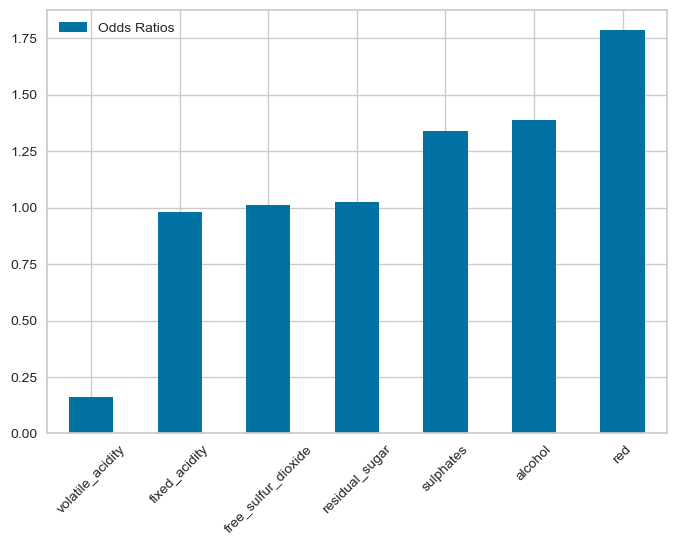

In [107]:
# Plot odds ratios
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(wines[important_features].columns, np.exp(lor.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Odds Ratios'})
importances.sort_values(by='Odds Ratios').plot(kind='bar', rot=45)

# Top Features Exploration

## Alcohol vs Residual Sugar

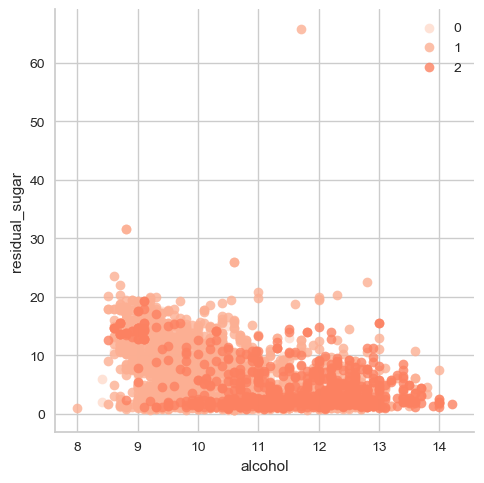

In [109]:
wines_subset = wines.copy()[important_features]
wines_subset['quality'] = wines.quality.map({3:0, 4:0, 5:1, 6:1, 7:2, 8:2, 9:2})

# Use the 'hue' argument to provide a factor variable
sns.lmplot(x="alcohol", y="residual_sugar", data=wines_subset.dropna(), fit_reg=False, hue='quality', legend=False, palette=sns.color_palette("Reds"))
 
# Move the legend to an empty part of the plot
plt.legend(loc='best')

## Alcohol Distribution by Quality and Color

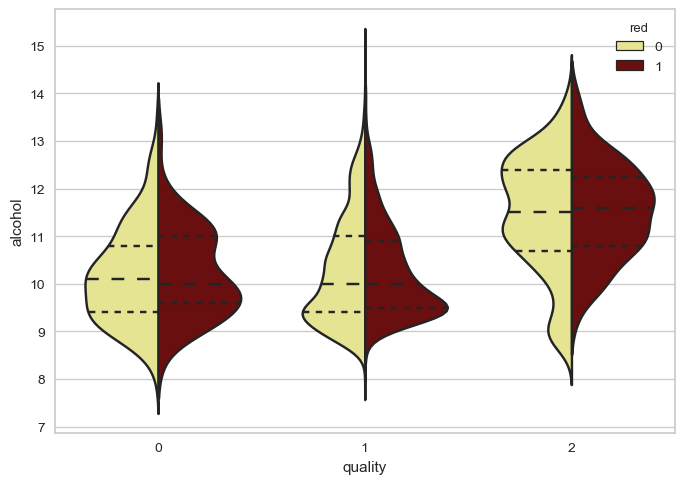

In [110]:
sns.violinplot(x='quality', 
               y="alcohol", 
               data=wines_subset, 
               hue='red', 
               split=True, 
               inner='quart', 
               palette={0: wine_colors['white'], 1: wine_colors['red']})

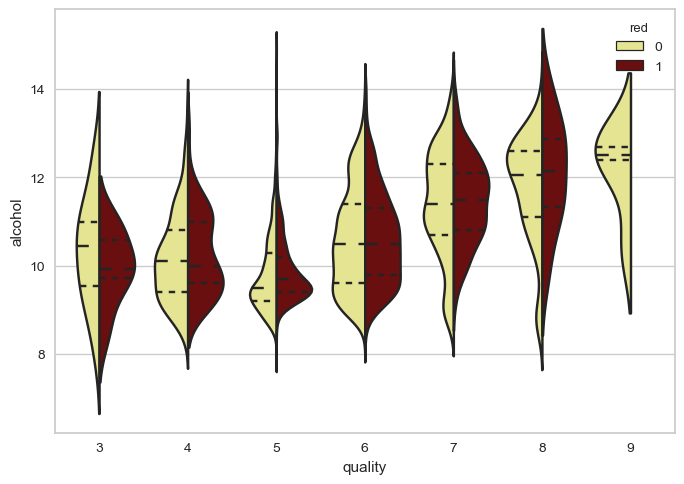

In [111]:
sns.violinplot(x='quality', y="alcohol", data=wines, hue='red', split=True, inner='quart', palette={0: wine_colors['white'], 1: wine_colors['red']})

## Residual Sugar Distribution by Quality and Color

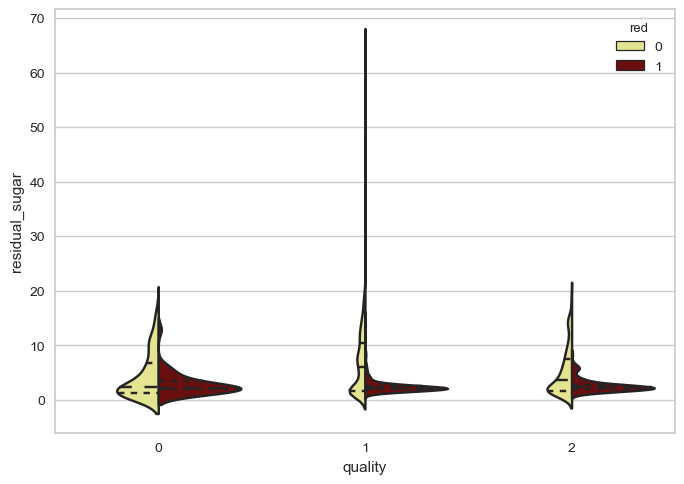

In [112]:
sns.violinplot(x='quality', 
               y="residual_sugar", 
               data=wines_subset, 
               hue='red', 
               split=True, 
               inner='quart', 
               palette={0: wine_colors['white'], 1: wine_colors['red']})

## Sulphates Distribution by Quality and Color

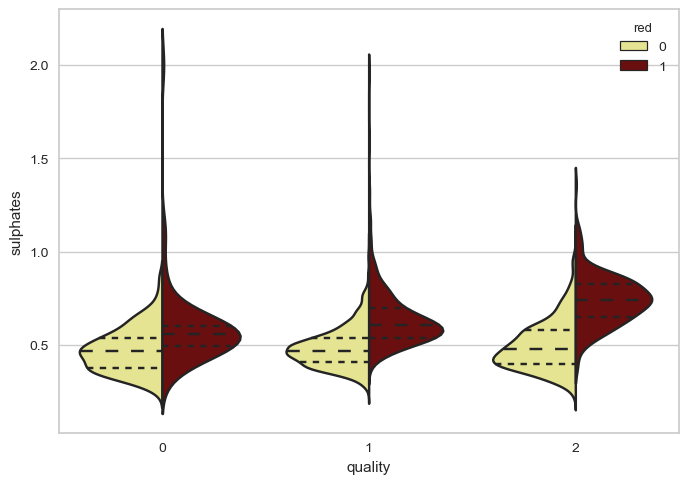

In [113]:
sns.violinplot(x='quality', 
               y="sulphates", 
               data=wines_subset, 
               hue='red', 
               split=True, 
               inner='quart', 
               palette={0: wine_colors['white'], 1: wine_colors['red']})

## Volatile Acidity Distribution by Quality and Color

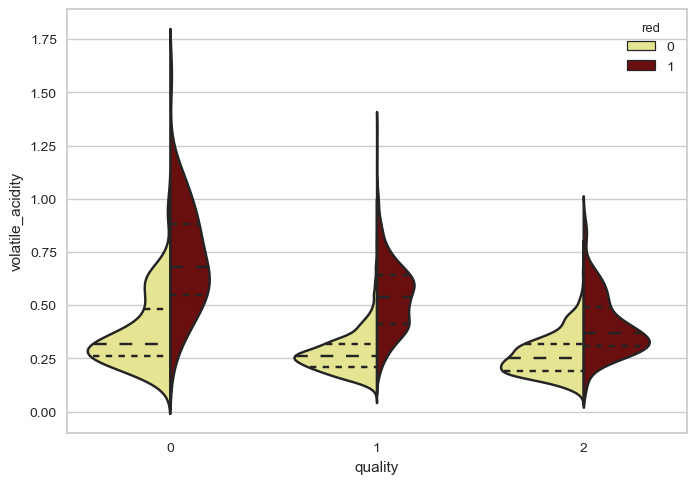

In [114]:
sns.violinplot(x='quality', 
               y="volatile_acidity", 
               data=wines_subset, 
               hue='red', 
               split=True, 
               inner='quart', 
               palette={0: wine_colors['white'], 1: wine_colors['red']})

## Fixed Acidity Distribution by Quality and Color

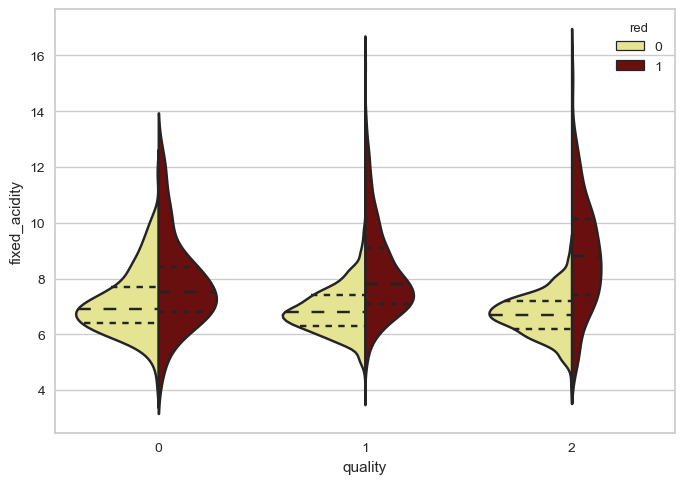

In [115]:
sns.violinplot(x='quality', 
               y="fixed_acidity", 
               data=wines_subset, 
               hue='red', 
               split=True, 
               inner='quart', 
               palette={0: wine_colors['white'], 1: wine_colors['red']})

## Correlation Heatmap of Top 7 Features

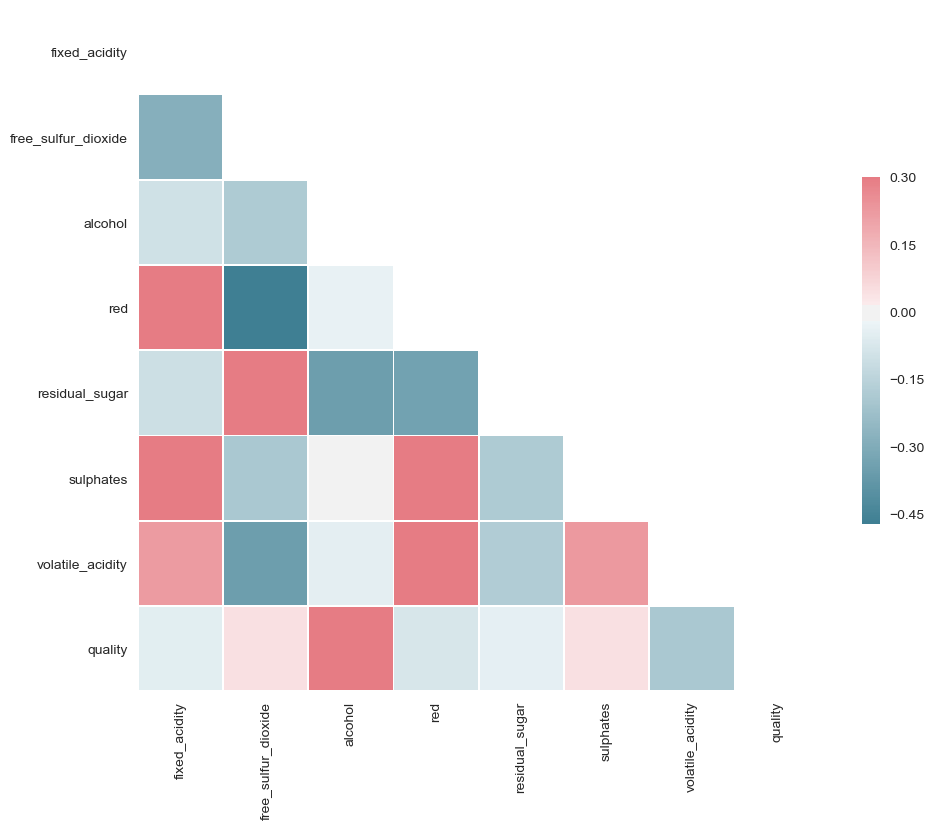

In [116]:
# Compute the correlation matrix
corr = wines_subset.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Sweetness Binning

This chart looked pretty cool, so I thought I'd see where our wines fall on the typical sweetness scale.

![sweetness chart](http://winefolly.wpengine.netdna-cdn.com/wp-content/uploads/2016/04/wine-sweetness-chart-wine-folly1.jpg#large)

In [117]:
sweetness_left = [0, 9, 18, 50]
sweetness_right = [9, 18, 50, 120]
sweetness_intervals = pd.IntervalIndex.from_arrays(sweetness_left, sweetness_right, name=['Dry', 'Off-Dry', 'Medium Dry/ Semi-Sweet', 'Medium Sweet'])

In [118]:
wines['sweetness'] = pd.cut(wines.residual_sugar, sweetness_intervals, labels=['Dry', 'Off-Dry', 'Medium Dry/ Semi-Sweet', 'Medium Sweet'])